In [29]:
import kaggle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import tensorflow as tf
import keras
from livelossplot import PlotLossesKeras

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [3]:
api = KaggleApi()
api.authenticate()

In [4]:
df = pd.read_csv('train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
df.drop_duplicates(subset="SentenceId", keep="first", inplace=True)


In [6]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


In [7]:
len(df)

8529

In [8]:
seqlen = df['Phrase'].apply(lambda x: len(x.split()))

C:\Users\addoa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Phrase', ylabel='Density'>

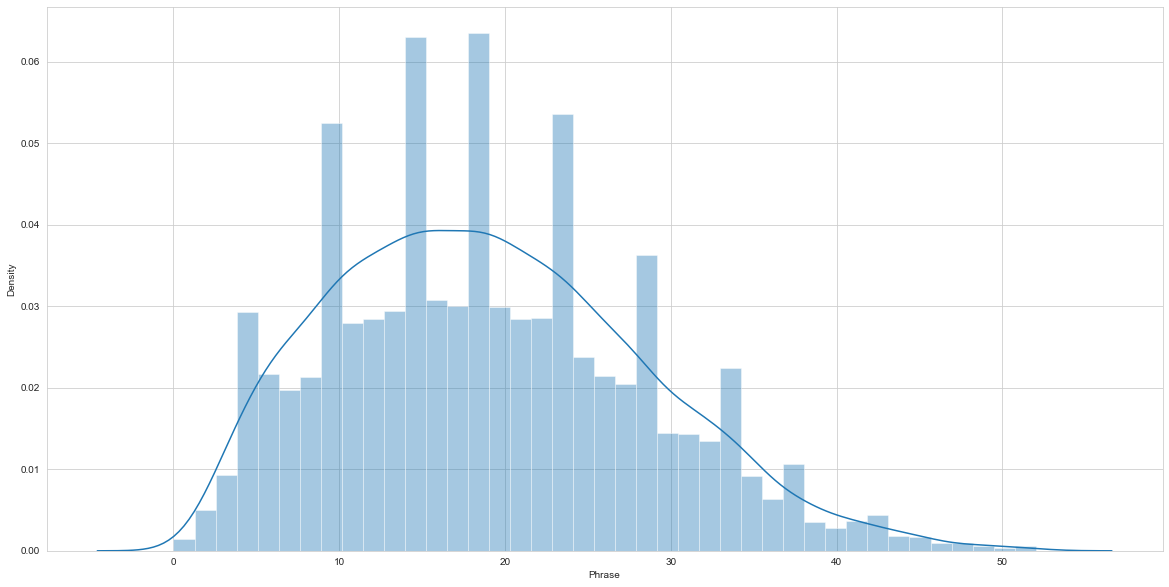

In [9]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 10))
sns.distplot(seqlen)

In [10]:
seq_len = 50

In [11]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')


In [12]:
tokens = tokenizer.encode_plus("this is an example string", max_length=seq_len,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')

In [13]:
tokens

{'input_ids': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[ 101, 1142, 1110, 1126, 1859, 5101,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]])>, 'attention_mask': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])>}

In [14]:
def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=seq_len,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

Xids = np.zeros((len(df), seq_len))
Xmask = np.zeros((len(df), seq_len))

for i, sentence in enumerate(df['Phrase']):
    Xids[i, :], Xmask[i, :] = tokenize(sentence)

0


In [15]:
Xids.shape

(8529, 50)

In [16]:
Xmask.shape

(8529, 50)

In [17]:
labels = df['Sentiment'].values

In [18]:
labels.shape

(8529,)

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [20]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [21]:
dataset = dataset.map(map_func)


In [22]:
dataset = dataset.shuffle(100000).batch(64)


In [23]:
ds_len = len(list(dataset))
split = 0.85 

train = dataset.take(round(ds_len*split))
val = dataset.skip(round(ds_len*split))

In [24]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [36]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation='elu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(64, activation='elu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(32, activation='elu')(X)
y = tf.keras.layers.Dense(1, activation='elu', name='outputs')(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

model.layers[2].trainable = False

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   input_ids[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 768)          0           tf_bert_model[1][0]              
____________________________________________________________________________________________

In [37]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=keras.losses.mean_squared_error)

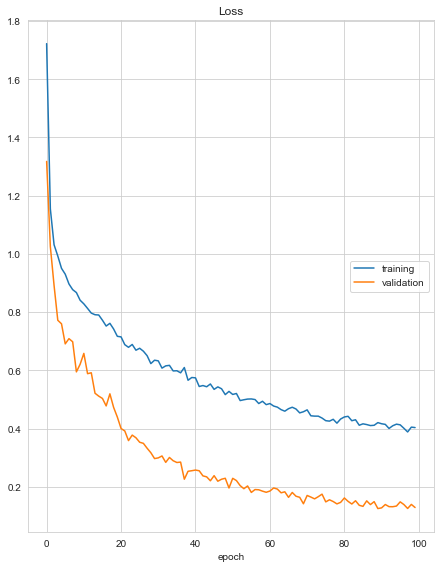

Loss
	training         	 (min:    0.389, max:    1.722, cur:    0.404)
	validation       	 (min:    0.126, max:    1.318, cur:    0.129)
114/114 [==============================] - 13s 117ms/step - loss: 0.4038 - val_loss: 0.1293


In [38]:
## batch size specified in generator
history = model.fit(train, 
                    validation_data = val, 
                    epochs = 100,
                    callbacks = [PlotLossesKeras()])

In [47]:
keras.models.save_model(model, "thismodel.h5py")

INFO:tensorflow:Assets written to: thismodel.h5py\assets


In [48]:
model_loaded = keras.models.load_model('thismodel.h5py')


ValueError: The two structures don't have the same nested structure.

First structure: type=dict str={'input_ids': TensorSpec(shape=(None, 5), dtype=tf.int32, name='input_ids/input_ids')}

Second structure: type=TensorSpec str=TensorSpec(shape=(None, 50), dtype=tf.int32, name='input_ids')

More specifically: Substructure "type=dict str={'input_ids': TensorSpec(shape=(None, 5), dtype=tf.int32, name='input_ids/input_ids')}" is a sequence, while substructure "type=TensorSpec str=TensorSpec(shape=(None, 50), dtype=tf.int32, name='input_ids')" is not
Entire first structure:
{'input_ids': .}
Entire second structure:
.

In [77]:
model.save_weights("moddy.h5")

In [54]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation='elu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(64, activation='elu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(32, activation='elu')(X)
y = tf.keras.layers.Dense(1, activation='elu', name='outputs')(X)

modelt = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

modelt.layers[2].trainable = False

modelt.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   input_ids[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 768)          0           tf_bert_model[2][0]              
____________________________________________________________________________________________

In [57]:
modelt.load_weights("moddy.h5")

In [61]:
exy = modelt.predict(tokenize("I love this movie very much."))

In [62]:
exy

array([[3.4654305]], dtype=float32)

In [76]:
exy2 = modelt.predict(tokenize("This movie was kind of really really bad."))
exy2

array([[0.37940913]], dtype=float32)